In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from scipy import signal
from sklearn.model_selection import GroupKFold
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, GlobalAveragePooling1D, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

## 데이터 불러오기

In [ ]:
file_path = '/content/drive/MyDrive/Colab Notebooks/machine-learning-programming/week02/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt'
column_names = ['user_id', 'activity', 'timestamp', 'x_accel', 'y_accel', 'z_accel']
df = pd.read_csv(file_path, sep=',', header=None, names=column_names, on_bad_lines='skip')
df['z_accel'] = df['z_accel'].str.rstrip(';')
df['z_accel'] = pd.to_numeric(df['z_accel'])

In [ ]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

In [ ]:
# 가속도 크기 추가
df['magnitude'] = np.sqrt(df['x_accel']**2 + df['y_accel']**2 + df['z_accel']**2)

In [ ]:
# 중력/신체 가속도 분리 (Butterworth 저주파 통과 필터)

# --- 1. 필터 파라미터 정의 ---
# WISDM 데이터셋은 20Hz로 샘플링
sampling_frequency = 20  # 샘플링 주파수 (Hz)
cutoff_frequency = 0.3   # 차단 주파수 (Hz). 0.3Hz 이하의 저주파 성분(중력)만 통과시킴
filter_order = 4         # 필터 차수. 높을수록 차단이 날카로워짐

# --- 2. Butterworth 필터 설계 및 적용을 위한 함수 정의 ---
def butter_lowpass_filter(data, cutoff, fs, order):
    """
    Butterworth 저주파 통과 필터를 데이터에 적용하는 함수.

    :param data: 필터링할 시계열 데이터 (e.g., df['x_accel'])
    :param cutoff: 차단 주파수 (Hz)
    :param fs: 샘플링 주파수 (Hz)
    :param order: 필터 차수
    :return: 필터링된 데이터
    """
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    # 필터 계수 (b, a) 생성
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    # filtfilt를 사용하여 위상 변이 없이 필터 적용
    filtered_data = signal.filtfilt(b, a, data)
    return filtered_data

# --- 3. 각 축에 필터 적용 ---
# 'grav' 컬럼에 필터링된 저주파 성분(중력)을 저장
df['grav_x'] = butter_lowpass_filter(df['x_accel'], cutoff_frequency, sampling_frequency, filter_order)
df['grav_y'] = butter_lowpass_filter(df['y_accel'], cutoff_frequency, sampling_frequency, filter_order)
df['grav_z'] = butter_lowpass_filter(df['z_accel'], cutoff_frequency, sampling_frequency, filter_order)

In [ ]:
# 신체 가속도
df['body_x'] = df['x_accel'] - df['grav_x']
df['body_y'] = df['y_accel'] - df['grav_y']
df['body_z'] = df['z_accel'] - df['grav_z']

In [ ]:
# 저크 신호 추가 (신체 가속도의 변화율)
df['jerk_x'] = df['body_x'].diff()
df['jerk_y'] = df['body_y'].diff()
df['jerk_z'] = df['body_z'].diff()

# diff()로 인해 생성된 첫 번째 행의 NaN 값을 0으로 채움
df.fillna(0, inplace=True)

In [ ]:
print(df.head())

   user_id activity       timestamp   x_accel    y_accel   z_accel  magnitude  \
0       33  Jogging  49105962326000 -0.694638  12.680544  0.503953  12.709551   
1       33  Jogging  49106062271000  5.012288  11.264028  0.953424  12.365693   
2       33  Jogging  49106112167000  4.903325  10.882658 -0.081722  11.936562   
3       33  Jogging  49106222305000 -0.612916  18.496431  3.023717  18.751973   
4       33  Jogging  49106332290000 -1.184970  12.108489  7.205164  14.139804   

     grav_x     grav_y    grav_z    body_x    body_y    body_z    jerk_x  \
0 -1.219639  13.035607  0.207571  0.525001 -0.355063  0.296382  0.000000   
1 -1.062786  12.665567  0.323215  6.075074 -1.401539  0.630209  5.550073   
2 -0.913344  12.303602  0.439083  5.816669 -1.420944 -0.520805 -0.258405   
3 -0.771474  11.950766  0.554862  0.158559  6.545665  2.468855 -5.658111   
4 -0.637296  11.608056  0.670239 -0.547674  0.500433  6.534925 -0.706233   

     jerk_y    jerk_z  
0  0.000000  0.000000  
1 -1.046

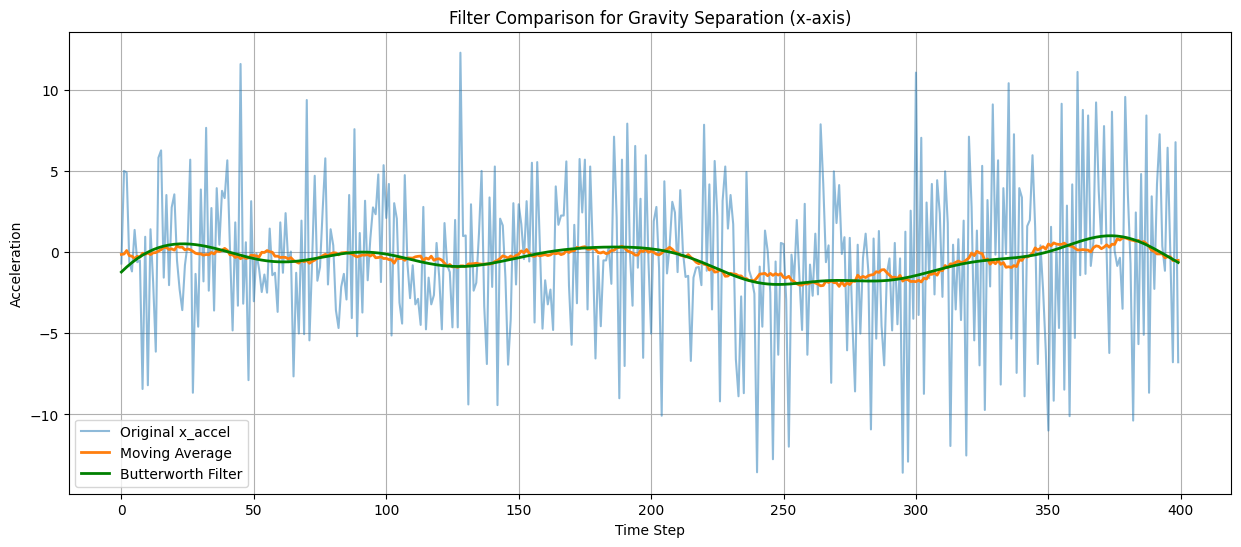

In [ ]:
# 시각화 비교를 위한 이동 평균 계산 (기존 방식)
rolling_window = 50
df['grav_x_ma'] = df['x_accel'].rolling(window=rolling_window, center=True, min_periods=1).mean()

# 그래프 그리기 (데이터의 일부만)
plt.figure(figsize=(15, 6))
plt.plot(df['x_accel'].iloc[:400], label='Original x_accel', alpha=0.5)
plt.plot(df['grav_x_ma'].iloc[:400], label='Moving Average', linewidth=2)
plt.plot(df['grav_x'].iloc[:400], label='Butterworth Filter', linewidth=2, color='green')
plt.title('Filter Comparison for Gravity Separation (x-axis)')
plt.xlabel('Time Step')
plt.ylabel('Acceleration')
plt.legend()
plt.grid(True)
plt.show()

## 데이터 전처리

In [ ]:
df.shape

(1086465, 17)

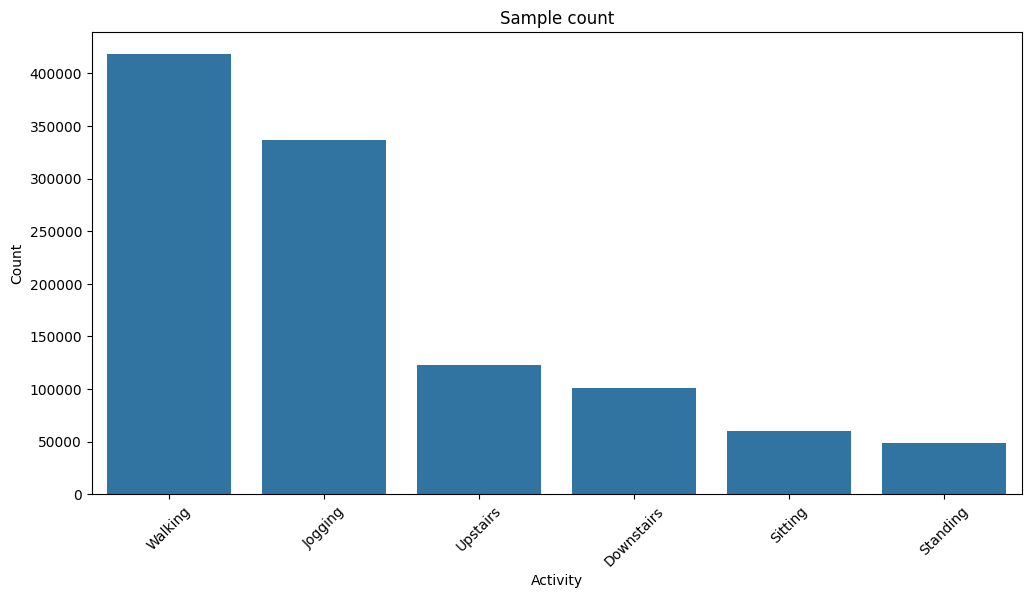

In [ ]:
plt.figure(figsize=(12, 6))

sns.countplot(x='activity', data=df, order=df['activity'].value_counts().index)

plt.title('Sample count')
plt.xlabel('Activity')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [ ]:
print(df.isnull().sum())

user_id      0
activity     0
timestamp    0
x_accel      0
y_accel      0
z_accel      0
magnitude    0
grav_x       0
grav_y       0
grav_z       0
body_x       0
body_y       0
body_z       0
jerk_x       0
jerk_y       0
jerk_z       0
grav_x_ma    0
dtype: int64


In [ ]:
label_encoder = LabelEncoder()
df['activity_encoded'] = label_encoder.fit_transform(df['activity'])

In [ ]:
for i, class_name in enumerate(label_encoder.classes_):
    print(f"'{class_name}'  ->  {i}")

'Downstairs'  ->  0
'Jogging'  ->  1
'Sitting'  ->  2
'Standing'  ->  3
'Upstairs'  ->  4
'Walking'  ->  5


In [ ]:
feature_columns = [
    'grav_x', 'grav_y', 'grav_z',    # 기울기 정보 (정적 활동 구분용)
    'body_x', 'body_y', 'body_z',    # 움직임 정보 (동적 활동 구분용)
    'magnitude',                     # 움직임 강도
    'jerk_x', 'jerk_y', 'jerk_z'     # 움직임 변화율
]

In [ ]:
X_df = df[feature_columns]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_df)
scaled_X_df = pd.DataFrame(X_scaled, columns=X_df.columns)

## 데이터 Windowing

In [ ]:
# 하이퍼파라미터 설정
TIME_STEPS = 80  # 80개의 타임스텝 (약 4초 분량)을 하나의 데이터로 사용
STEP = 40        # 40개 타임스텝씩 겹치면서 윈도우 생성

# 윈도우(세그먼트) 생성 함수
def create_segments(features, labels, user_ids, time_steps, step):
    segments = []
    segment_labels = []
    groups = []
    for i in range(0, len(features) - time_steps, step):
        segment = features.iloc[i: i + time_steps].values
        label = stats.mode(labels.iloc[i: i + time_steps])[0]
        # 윈도우의 user_id는 중앙값(median) 또는 최빈값(mode)을 사용
        group_id = stats.mode(user_ids.iloc[i: i + time_steps])[0]

        segments.append(segment)
        segment_labels.append(label)
        groups.append(group_id)

    return np.array(segments), np.array(segment_labels), np.array(groups)

In [ ]:
# 데이터 가공 실행
X_segmented, y_segmented, groups = create_segments(
    scaled_X_df,
    df['activity_encoded'],
    df['user_id'],
    TIME_STEPS,
    STEP
)

In [ ]:
# 레이블 원-핫 인코딩
num_classes = len(label_encoder.classes_)
y_one_hot = to_categorical(y_segmented, num_classes=num_classes)

In [ ]:
print("--- 가공 후 데이터 형태 ---")
print("X (입력 데이터) shape:", X_segmented.shape)
print("y (레이블 데이터) shape:", y_one_hot.shape)

--- 가공 후 데이터 형태 ---
X (입력 데이터) shape: (27160, 80, 10)
y (레이블 데이터) shape: (27160, 6)


## 모델 구축, 학습 및 평가

In [ ]:
input_shape = (TIME_STEPS, X_segmented.shape[2])

In [ ]:
def create_cnn_model():
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', kernel_regularizer=l2(0.001), input_shape=input_shape),
        Conv1D(filters=128, kernel_size=3, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.5),
        MaxPooling1D(pool_size=2),
        GlobalAveragePooling1D(),
        Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
def create_lstm_model():
    model = Sequential([
        Bidirectional(LSTM(128, return_sequences=True), input_shape=input_shape),
        Dropout(0.5),
        Bidirectional(LSTM(128)),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
def create_hybrid_model():
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Dropout(0.5),
        Bidirectional(LSTM(100)),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# GroupKFold 설정
n_splits = 5
gkf = GroupKFold(n_splits=n_splits)

In [ ]:
# 모델 생성 함수와 이름을 튜플로 묶어 루프를 실행
model_creators = [
    (create_cnn_model, "1D CNN"),
    (create_lstm_model, "LSTM"),
    (create_hybrid_model, "CNN+LSTM Hybrid")
]

In [ ]:
cv_results = {}
histories = {}
all_predictions = {}
for _, model_name in model_creators:
    all_predictions[model_name] = {'true': [], 'pred': []}

In [ ]:
for model_creator, model_name in model_creators:
    acc_per_fold = []
    loss_per_fold = []
    histories[model_name] = []
    fold_no = 1

    print(f"\n{'='*50}\nRunning Cross-Validation for {model_name}\n{'='*50}")

    for train_index, val_index in gkf.split(X_segmented, y_one_hot, groups=groups):
        X_train, X_val = X_segmented[train_index], X_segmented[val_index]
        y_train, y_val = y_one_hot[train_index], y_one_hot[val_index]

        print(f"--- Fold {fold_no} ---")

        model = model_creator()

        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

        # 검증 손실이 3 epoch 동안 개선되지 않으면 학습률을 0.5배로 줄임
        lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

        history = model.fit(
            X_train, y_train,
            epochs=80,
            batch_size=64,
            validation_data=(X_val, y_val),
            callbacks=[early_stopping, lr_scheduler],
            verbose=0
        )

        scores = model.evaluate(X_val, y_val, verbose=0)
        print(f'> Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')

        # 1. 검증 데이터에 대한 예측 수행
        y_pred_probs = model.predict(X_val)

        # 2. 확률값(one-hot)을 클래스 인덱스(정수)로 변환
        y_pred_classes = np.argmax(y_pred_probs, axis=1)
        y_true_classes = np.argmax(y_val, axis=1)

        # 3. 해당 폴드의 실제값과 예측값을 리스트에 추가
        all_predictions[model_name]['true'].extend(y_true_classes)
        all_predictions[model_name]['pred'].extend(y_pred_classes)

        acc_per_fold.append(scores[1] * 100)
        loss_per_fold.append(scores[0])
        histories[model_name].append(history)

        fold_no += 1

    cv_results[model_name] = (np.mean(acc_per_fold), np.std(acc_per_fold))


Running Cross-Validation for 1D CNN
--- Fold 1 ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 21: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 24: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 27: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
> Score for fold 1: loss of 0.3613167405128479; compile_metrics of 91.36583805084229%
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
--- Fold 2 ---

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 19: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
> Score for fold 2: loss of 0.5026927590370178; compile_metrics of 84.22602415084839%
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
--- Fold 3 ---

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 20: Reduce

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
> Score for fold 1: loss of 0.31102368235588074; compile_metrics of 90.32378196716309%
168/168 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
--- Fold 2 ---

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
> Score for fold 2: loss of 0.4492889940738678; compile_metrics of 88.66187930107117%
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
--- Fold 3 ---

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
> Score for fol

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
> Score for fold 1: loss of 0.3194398283958435; compile_metrics of 91.31001234054565%
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
--- Fold 2 ---

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
> Score for fold 2: loss of 0.42610883712768555; compile_metrics of 86.54518723487854%
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
--- Fold 3 ---

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
> Score for fol

## 결과 비교 및 시각화

In [ ]:
history_cnn = histories['1D CNN'][0]
history_lstm = histories['LSTM'][0]
history_hybrid = histories['CNN+LSTM Hybrid'][0]

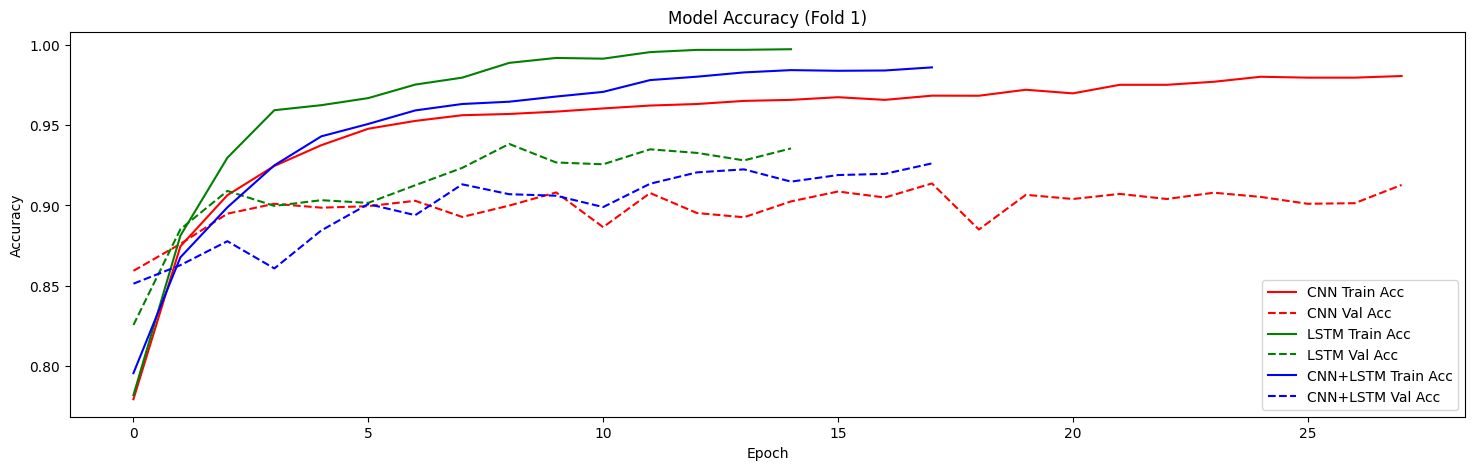

In [ ]:
# 정확도 그래프
plt.figure(figsize=(18, 5))
plt.plot(history_cnn.history['accuracy'], 'r-', label='CNN Train Acc')
plt.plot(history_cnn.history['val_accuracy'], 'r--', label='CNN Val Acc')
plt.plot(history_lstm.history['accuracy'], 'g-', label='LSTM Train Acc')
plt.plot(history_lstm.history['val_accuracy'], 'g--', label='LSTM Val Acc')
plt.plot(history_hybrid.history['accuracy'], 'b-', label='CNN+LSTM Train Acc')
plt.plot(history_hybrid.history['val_accuracy'], 'b--', label='CNN+LSTM Val Acc')
plt.title('Model Accuracy (Fold 1)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

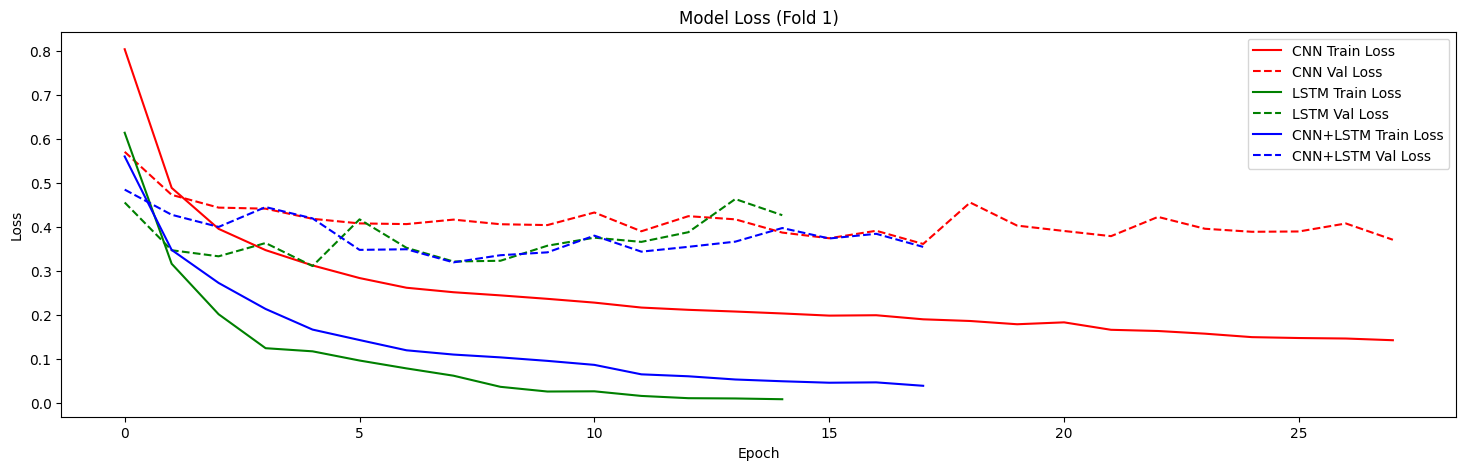

In [ ]:
# 손실 그래프
plt.figure(figsize=(18, 5))
plt.plot(history_cnn.history['loss'], 'r-', label='CNN Train Loss')
plt.plot(history_cnn.history['val_loss'], 'r--', label='CNN Val Loss')
plt.plot(history_lstm.history['loss'], 'g-', label='LSTM Train Loss')
plt.plot(history_lstm.history['val_loss'], 'g--', label='LSTM Val Loss')
plt.plot(history_hybrid.history['loss'], 'b-', label='CNN+LSTM Train Loss')
plt.plot(history_hybrid.history['val_loss'], 'b--', label='CNN+LSTM Val Loss')
plt.title('Model Loss (Fold 1)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# 최종 성능 비교
print("\n--- 최종 모델 성능 비교 (User-wise 5-Fold CV Accuracy) ---")
for model_name, (mean_acc, std_acc) in cv_results.items():
    print(f"{model_name}: {mean_acc:.2f}% (+/- {std_acc:.2f}%)")


--- 최종 모델 성능 비교 (User-wise 5-Fold CV Accuracy) ---
1D CNN: 87.58% (+/- 2.59%)
LSTM: 89.49% (+/- 2.73%)
CNN+LSTM Hybrid: 87.49% (+/- 3.91%)




      종합 성능 평가 (5-Fold CV 결과 종합)

--- Classification Report for 1D CNN ---
              precision    recall  f1-score   support

  Downstairs       0.67      0.72      0.69      2513
     Jogging       0.95      0.94      0.95      8412
     Sitting       0.90      0.91      0.91      1494
    Standing       0.93      0.86      0.90      1211
    Upstairs       0.65      0.78      0.71      3068
     Walking       0.94      0.88      0.91     10462

    accuracy                           0.88     27160
   macro avg       0.84      0.85      0.84     27160
weighted avg       0.88      0.88      0.88     27160



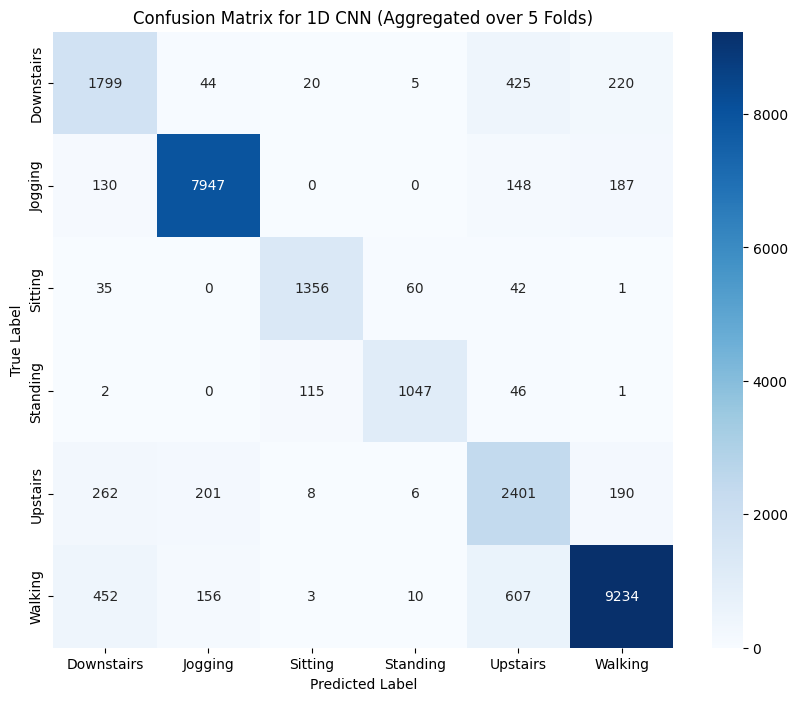


--- Classification Report for LSTM ---
              precision    recall  f1-score   support

  Downstairs       0.67      0.78      0.72      2513
     Jogging       0.96      0.97      0.96      8412
     Sitting       0.89      0.91      0.90      1494
    Standing       0.91      0.86      0.89      1211
    Upstairs       0.72      0.72      0.72      3068
     Walking       0.95      0.92      0.94     10462

    accuracy                           0.89     27160
   macro avg       0.85      0.86      0.86     27160
weighted avg       0.90      0.89      0.90     27160



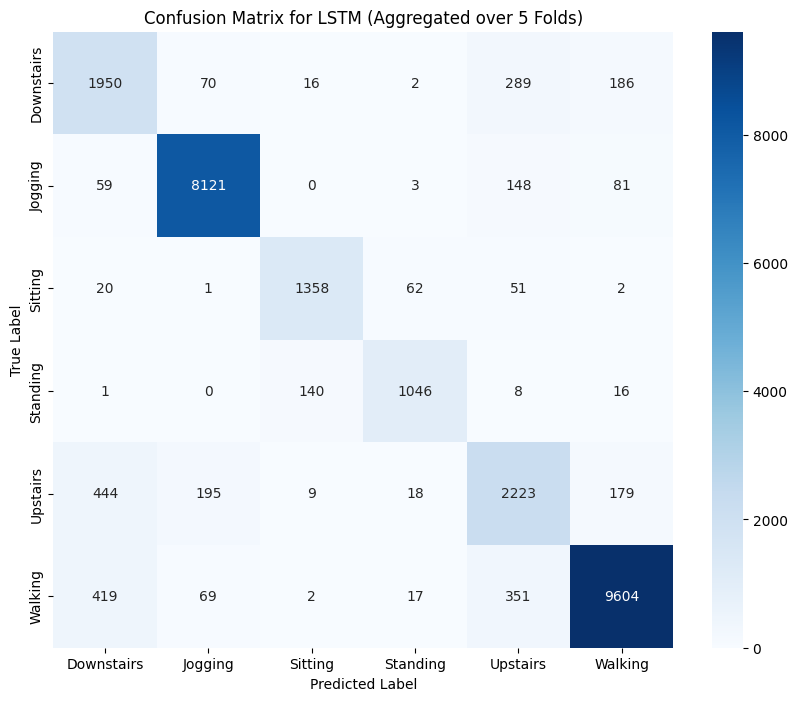


--- Classification Report for CNN+LSTM Hybrid ---
              precision    recall  f1-score   support

  Downstairs       0.74      0.74      0.74      2513
     Jogging       0.93      0.95      0.94      8412
     Sitting       0.90      0.93      0.91      1494
    Standing       0.92      0.88      0.90      1211
    Upstairs       0.63      0.76      0.69      3068
     Walking       0.95      0.87      0.91     10462

    accuracy                           0.87     27160
   macro avg       0.84      0.85      0.85     27160
weighted avg       0.88      0.87      0.88     27160



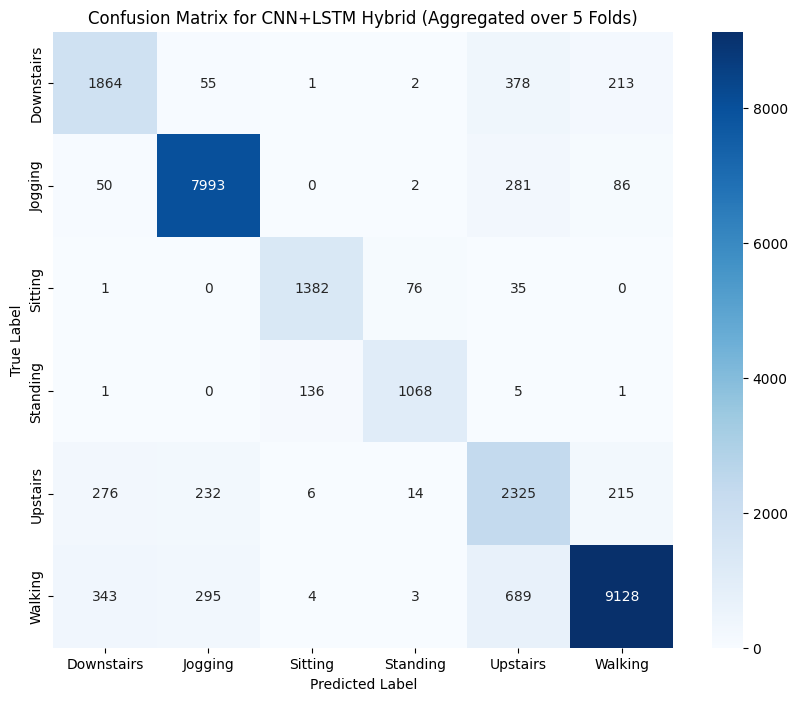

In [ ]:
# 레이블 인코더에서 클래스 이름 가져오기
class_names = label_encoder.classes_

print("\n\n" + "="*50)
print("      종합 성능 평가 (5-Fold CV 결과 종합)")
print("="*50)

for model_name, results in all_predictions.items():
    y_true_all = results['true']
    y_pred_all = results['pred']

    # 1. Classification Report 출력
    print(f"\n--- Classification Report for {model_name} ---")
    print(classification_report(y_true_all, y_pred_all, target_names=class_names))

    # 2. Confusion Matrix 시각화
    cm = confusion_matrix(y_true_all, y_pred_all)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix for {model_name} (Aggregated over 5 Folds)')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()